In [1]:
# ============================================================
# MP_2 — Imbalanced Classification (Mammography Dataset)
# Data Mining & Text Analytics — MATH 3310
#
# This script:
#   - Loads the Mammography dataset from an ARFF file
#   - Performs exploratory data analysis (EDA)
#   - Builds preprocessing and modeling pipelines
#   - Trains and evaluates multiple Random Forest–based models
#   - Uses different cross-validation strategies
#   - Applies class weights, SMOTE, and random undersampling
#   - Compares models using accuracy, balanced accuracy, F1, and G-mean
#   - Examines feature importance with impurity, permutation, and SHAP
#
# Each section is labeled to match parts (a)–(i) of the project description.
# ============================================================

In [32]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


from scipy.io import arff

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [17]:
# Load the .arff file

path = "C:/Users/girli/OneDrive/Documents/Math3310/phpn1jVwe.arff"
data, meta = arff.loadarff(path)

In [18]:
# Convert to DataFrame

df = pd.DataFrame(data)

In [19]:
df['class'] = df['class'].str.decode('utf-8')

In [20]:
# Save to CSV file

csv_file_name = 'Mammography.csv'
df.to_csv(csv_file_name, index=False)

print(f"Data saved to {csv_file_name}")

Data saved to Mammography.csv


In [21]:
df.head()

,attr1,attr2,attr3,attr4,attr5,attr6,class
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,-1
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,-1
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,-1
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,-1
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,-1


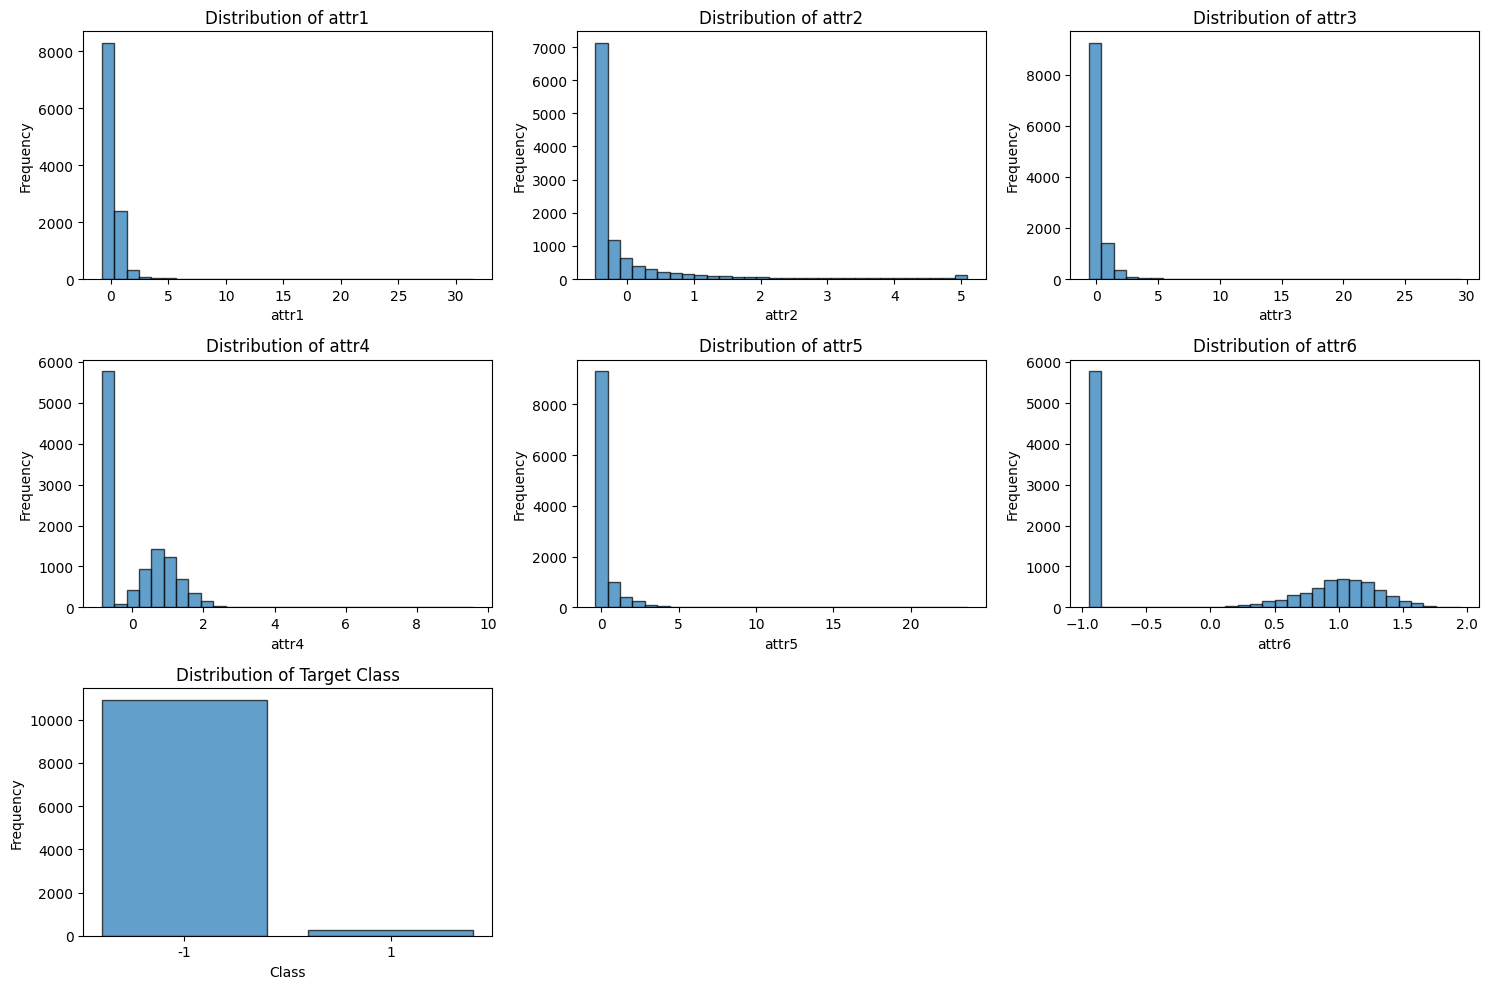

In [22]:
# part a) Visualize the distributions of continuous features and target class
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot histograms for each continuous feature
for i, col in enumerate(['attr1', 'attr2', 'attr3', 'attr4', 'attr5', 'attr6']):
    axes[i].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Plot the target class distribution
axes[6].bar(df['class'].value_counts().index, df['class'].value_counts().values, edgecolor='black', alpha=0.7)
axes[6].set_title('Distribution of Target Class')
axes[6].set_xlabel('Class')
axes[6].set_ylabel('Frequency')

# Hide the last unused subplot
axes[7].axis('off')
axes[8].axis('off')

plt.tight_layout()
plt.show()

In [23]:
# part b1) Features and target
X = df.drop(columns='class')
y = df['class'].astype(int)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify numeric and categorical feature names
numeric_cols = X.select_dtypes(include=['number', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Train shapes:" , X_train.shape, y_train.shape)
print("Test shapes:" , X_test.shape, y_test.shape)

Train shapes: (8946, 6) (8946,)
Test shapes: (2237, 6) (2237,)


In [24]:
# part b2) Use Column Transformer and pipeline
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# Pipeline with RandomForest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


5-fold CV accuracy on training set: mean=0.7637, std=0.0106
CV fold accuracies: [0.76274864 0.75526886 0.77517359 0.74942759 0.77602169]

Test set accuracy: 0.9861

Test set balanced accuracy: 0.7395

Classification report on test set:
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      2185
           1       0.86      0.48      0.62        52

    accuracy                           0.99      2237
   macro avg       0.92      0.74      0.81      2237
weighted avg       0.98      0.99      0.98      2237

Confusion matrix on test set:


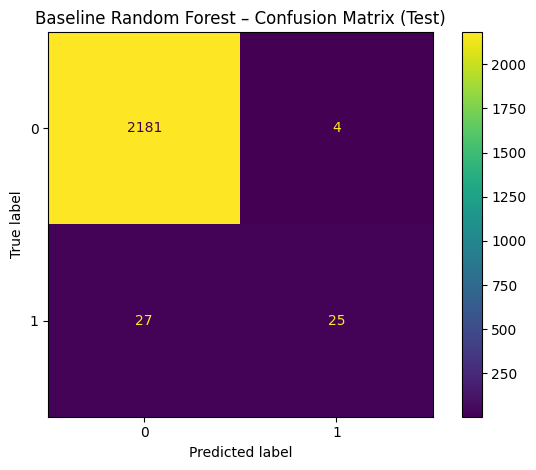

In [25]:
# part b3) 5-fold stratified cross-validation on the training set

#Add random seed for reproducibility
np.random.seed(100)

#Cross validation with KFold
cv=KFold(n_splits=5, shuffle=True, random_state=100)

#Fit the pipeline using cross validation
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=cv, scoring='balanced_accuracy')

print(f"5-fold CV accuracy on training set: mean={cv_scores.mean():.4f}, std={cv_scores.std():.4f}")
print("CV fold accuracies:", cv_scores)

# Fit on full training set and evaluate on test set
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)

print(f"\nTest set accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\nTest set balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print("\nClassification report on test set:")
print(classification_report(y_test, y_pred))

print("Confusion matrix on test set:")
cm_baseline = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm_baseline).plot()
plt.title("Baseline Random Forest – Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

In [31]:
# part c) GridSearch for two models

pipe_decicion_tree = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=0)),
    ]
)
# Define hyperparameter grid for RandomForest
param_grid = [
    {
        "classifier": [DecisionTreeClassifier(random_state=0)],
        "classifier__max_depth": [2, 3, 4],
    },
    {
        "classifier": [RandomForestClassifier(random_state=0, n_jobs=-1)],
        "classifier__n_estimators": [300, 500, 1000],
    },
    {
        "classifier": [LogisticRegression(random_state=0, max_iter=1000)],
        "classifier__C": [0.01, 1, 100]
    }
]

# GridSearchCV with 5-fold CV
grid_search = GridSearchCV(
    pipe_decicion_tree, 
    param_grid, 
    cv=5, 
    scoring='balanced_accuracy', 
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

best_pipe = grid_search.best_estimator_
y_pred = best_pipe.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)

# Evaluate on test set
tuned_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy with tuned model: {tuned_accuracy:.4f}")
print(f"Test set balanced accuracy with tuned model: {bal_acc:.4f}")
print(f"Original test set accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Improvement: {(tuned_accuracy - accuracy_score(y_test, y_pred)):.4f}")

cm_best = confusion_matrix(y_test, y_pred)
print(cm_best)

ConfusionMatrixDisplay(confusion_matrix=cm_best).plot()
plt.title("Best Model (GridSearch) – Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

NameError: name 'LogisticRegression' is not defined

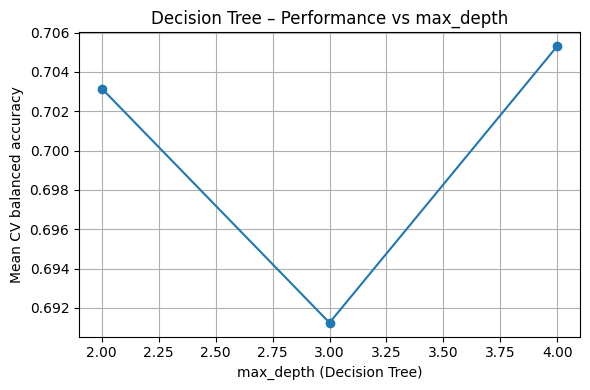

In [29]:
results = pd.DataFrame(grid_search.cv_results_)

# Decision Tree: mean balanced accuracy vs max_depth
mask_dt = results["param_classifier"].astype(str).str.contains("DecisionTreeClassifier")
dt_results = results[mask_dt]

if not dt_results.empty:
    plt.figure(figsize=(6, 4))
    plt.plot(
        dt_results["param_classifier__max_depth"],
        dt_results["mean_test_score"],
        marker="o",
    )
    plt.xlabel("max_depth (Decision Tree)")
    plt.ylabel("Mean CV balanced accuracy")
    plt.title("Decision Tree – Performance vs max_depth")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# part d) Use standard KFold with shuffling instead of StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"5-fold KFold (shuffled) CV accuracy on training set: mean={cv_scores_kfold.mean():.4f}, std={cv_scores_kfold.std():.4f}")
print("CV fold accuracies:", cv_scores_kfold)

# (Optional) compare to previous stratified CV if available
if 'cv_scores' in globals():
    print(f"Previous StratifiedKFold mean={cv_scores.mean():.4f}, std={cv_scores.std():.4f}")

# Fit and evaluate using the same pipeline
pipeline.fit(X_train, y_train)
y_pred_kfold = pipeline.predict(X_test)

print(f"\nTest set accuracy: {accuracy_score(y_test, y_pred_kfold):.4f}")
print("\nClassification report on test set:")
print(classification_report(y_test, y_pred_kfold))
print("Confusion matrix on test set:")
print(confusion_matrix(y_test, y_pred_kfold))

5-fold KFold (shuffled) CV accuracy on training set: mean=0.9871, std=0.0016
CV fold accuracies: [0.9849162  0.98993851 0.98714366 0.98714366 0.98658468]
Previous StratifiedKFold mean=0.9878, std=0.0011

Test set accuracy: 0.9861

Classification report on test set:
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      2185
           1       0.86      0.48      0.62        52

    accuracy                           0.99      2237
   macro avg       0.92      0.74      0.81      2237
weighted avg       0.98      0.99      0.98      2237

Confusion matrix on test set:
[[2181    4]
 [  27   25]]


In [44]:
# part e) Stratified 5-fold CV
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

weighted_opts = {
    'balanced': 'balanced',
    'balanced_subsample': 'balanced_subsample'
}

for name, cw in weighted_opts.items():
    pipe_w = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight=cw, n_jobs=-1))
    ])
    scores = cross_val_score(pipe_w, X_train, y_train, cv=cv_strat, scoring='accuracy', n_jobs=-1)
    y_pred_cv = cross_val_predict(pipe_w, X_train, y_train, cv=cv_strat, n_jobs=-1)

    print(f"Weighted RF ({name}) 5-fold CV accuracy: mean={scores.mean():.4f}, std={scores.std():.4f}")
    print("Fold accuracies:", scores)
    print("Aggregated classification report (training folds):")
    print(classification_report(y_train, y_pred_cv))
    print("Aggregated confusion matrix (training folds):")
    print(confusion_matrix(y_train, y_pred_cv))
    print("-" * 60)

# Compare to previous stratified CV (if available)
if 'cv_scores' in globals():
    print(f"Previous unweighted pipeline 5-fold CV mean accuracy: {cv_scores.mean():.4f}, std: {cv_scores.std():.4f}")

Weighted RF (balanced) 5-fold CV accuracy: mean=0.9864, std=0.0008
Fold accuracies: [0.9849162  0.98714366 0.98658468 0.98658468 0.98658468]
Aggregated classification report (training folds):
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      8738
           1       0.87      0.49      0.62       208

    accuracy                           0.99      8946
   macro avg       0.93      0.74      0.81      8946
weighted avg       0.99      0.99      0.98      8946

Aggregated confusion matrix (training folds):
[[8723   15]
 [ 107  101]]
------------------------------------------------------------
Weighted RF (balanced_subsample) 5-fold CV accuracy: mean=0.9866, std=0.0008
Fold accuracies: [0.98659218 0.98770263 0.98602571 0.98714366 0.98546674]
Aggregated classification report (training folds):
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      8738
           1       0.88      0.49   

In [45]:
# part f) Apply SMOTE and Random UnderSampling, compare via stratified 5-fold CV

# Pipelines (preprocessor already defined in the notebook)
pipe_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

pipe_rus = ImbPipeline([
    ('preprocessor', preprocessor),
    ('rus', RandomUnderSampler(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# 5-fold stratified CV on training set
scores_smote = cross_val_score(pipe_smote, X_train, y_train, cv=cv_strat, scoring='accuracy', n_jobs=-1)
scores_rus   = cross_val_score(pipe_rus,   X_train, y_train, cv=cv_strat, scoring='accuracy', n_jobs=-1)

print("SMOTE  5-fold accuracy: mean={:.4f}, std={:.4f}".format(scores_smote.mean(), scores_smote.std()))
print("RUS    5-fold accuracy: mean={:.4f}, std={:.4f}".format(scores_rus.mean(),   scores_rus.std()))

# Aggregated (out-of-fold) predictions for detailed metrics
y_oof_smote = cross_val_predict(pipe_smote, X_train, y_train, cv=cv_strat, n_jobs=-1)
y_oof_rus   = cross_val_predict(pipe_rus,   X_train, y_train, cv=cv_strat, n_jobs=-1)

print("\nSMOTE - aggregated classification report (train folds):")
print(classification_report(y_train, y_oof_smote))
print("Confusion matrix:\n", confusion_matrix(y_train, y_oof_smote))

print("\nRUS - aggregated classification report (train folds):")
print(classification_report(y_train, y_oof_rus))
print("Confusion matrix:\n", confusion_matrix(y_train, y_oof_rus))

# Optional: fit each on full training set and evaluate on the held-out test set
pipe_smote.fit(X_train, y_train)
pipe_rus.fit(X_train, y_train)

y_test_smote = pipe_smote.predict(X_test)
y_test_rus   = pipe_rus.predict(X_test)

print("\nTest set accuracy SMOTE: {:.4f}".format(accuracy_score(y_test, y_test_smote)))
print("Test set accuracy RUS:   {:.4f}".format(accuracy_score(y_test, y_test_rus)))

print("\nTest set report SMOTE:")
print(classification_report(y_test, y_test_smote))
print("\nTest set report RUS:")
print(classification_report(y_test, y_test_rus))

SMOTE  5-fold accuracy: mean=0.9779, std=0.0022
RUS    5-fold accuracy: mean=0.9129, std=0.0042

SMOTE - aggregated classification report (train folds):
              precision    recall  f1-score   support

          -1       0.99      0.98      0.99      8738
           1       0.52      0.73      0.60       208

    accuracy                           0.98      8946
   macro avg       0.76      0.85      0.80      8946
weighted avg       0.98      0.98      0.98      8946

Confusion matrix:
 [[8597  141]
 [  57  151]]

RUS - aggregated classification report (train folds):
              precision    recall  f1-score   support

          -1       1.00      0.91      0.95      8738
           1       0.19      0.86      0.31       208

    accuracy                           0.91      8946
   macro avg       0.59      0.89      0.63      8946
weighted avg       0.98      0.91      0.94      8946

Confusion matrix:
 [[7988  750]
 [  29  179]]

Test set accuracy SMOTE: 0.9835
Test set accu

In [ ]:
# part g) Calculate error rate, f1 score, and G-mean

In [ ]:
# part h) discus the strengths and limitations of each approach in the context of this analysis.

In [ ]:
# part i) Plot the mean decrease in impurity-based feature importance, permutation feature im-
# portance, and SHAP feature importance for the optimal model. Do you observe any
# differences? Discuss your observations

In [ ]:
# Discussion:

# What do I believe I did well on this assignment?

# What was the most challenging part of this assignment?

# What would have made this assignment a better experience?

# What do I need help with?